# Соревнование на kaggle. Классификация изображений

Обработка контента телекомпании FOX. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом соревновании  необходимо было классифицировать персонажей, проживающих в Спрингфилде.





### Установка зависимостей

In [1]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [2]:
# нам необходима версия pillow  5.3.0
# удалим старую версию и установим новую
# !pip uninstall -y Pillow
# !pip install Pillow==5.3.0
import PIL
print(PIL.PILLOW_VERSION)
# здесь должна быть версия 5.3.0. если это не так перехгрузите данный ноутбук:
# Menu > Runtime > Restart Runtime

7.1.2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: PILLOW_VERSION is deprecated and will be removed in a future release. Use __version__ instead.
  


In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
!ls -l /content/drive/MyDrive/Colab_Notebooks/journey-springfield.zip

-rw------- 1 root root 546224286 Nov 14 20:12 /content/drive/MyDrive/Colab_Notebooks/journey-springfield.zip


In [5]:
!unzip -q /content/drive/MyDrive/Colab_Notebooks/journey-springfield.zip

In [ ]:
!ls -l testset

total 36
drwxr-xr-x 2 root root 36864 Nov 29 11:45 testset


In [6]:
!ls -1

characters_illustration.png
drive
sample_data
sample_submission.csv
testset
train


In [7]:
!nvidia-smi
import torch
torch.cuda.is_available()

Wed Nov 30 14:18:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [8]:
import pickle
import numpy as np
import pandas as pd
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import transforms, datasets
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [9]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
BATCH_SIZE = 256
# работаем на видеокарте
DEVICE = torch.device("cuda")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


In [18]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))
train_labels = [path.parent.name for path in train_val_files]

Не использую валидационную выборку, так как данных очень мало

In [ ]:
# uncomment if you have problem with pillow
# def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
# Image.register_extension = register_extension
# def register_extensions(id, extensions): 
#     for extension in extensions: register_extension(id, extension)
# Image.register_extensions = register_extensions

Давайте посмотрим на наших героев внутри датасета.

Посмотрим на баланс классов

In [19]:
data = pd.Series(train_labels).value_counts().sort_values()
data

lionel_hutz                    3
troy_mcclure                   8
disco_stu                      8
miss_hoover                   17
gil                           27
fat_tony                      27
otto_mann                     32
sideshow_mel                  40
agnes_skinner                 42
rainier_wolfcastle            45
cletus_spuckler               47
snake_jailbird                55
professor_john_frink          65
martin_prince                 71
patty_bouvier                 72
ralph_wiggum                  89
carl_carlson                  98
selma_bouvier                103
barney_gumble                106
groundskeeper_willie         121
maggie_simpson               128
waylon_smithers              181
mayor_quimby                 246
lenny_leonard                310
nelson_muntz                 358
edna_krabappel               457
comic_book_guy               469
kent_brockman                498
apu_nahasapeemapetilon       623
sideshow_bob                 877
abraham_gr

Видно, что данные сильно разбалансированы. Поэтому я провожу здесь аугментацию

---



In [20]:
augment = transforms.RandomChoice([
    transforms.Compose([
        transforms.Resize(size=300, max_size=301),
        transforms.CenterCrop(size=300),
        transforms.RandomCrop(250)
    ]),
    transforms.RandomRotation(degrees=(-25, 25)),
    transforms.RandomHorizontalFlip(p=1),
])
train_transforms = transforms.Compose([
    augment,
    transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
    transforms.Lambda(lambda x: np.array(x, dtype="float32") / 255),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ,
])
train_dataset = datasets.ImageFolder(root=TRAIN_DIR, transform=train_transforms)


Использую WeightedRandomSampler, чтобы изображения из маленьких классов встречались чаще, а из больших реже.

Таким образом, при помощи ауиментации и sampler получается более-менее сбалансированная выборка

In [21]:
class_weight = 1/data
class_weight

lionel_hutz                 0.333333
troy_mcclure                0.125000
disco_stu                   0.125000
miss_hoover                 0.058824
gil                         0.037037
fat_tony                    0.037037
otto_mann                   0.031250
sideshow_mel                0.025000
agnes_skinner               0.023810
rainier_wolfcastle          0.022222
cletus_spuckler             0.021277
snake_jailbird              0.018182
professor_john_frink        0.015385
martin_prince               0.014085
patty_bouvier               0.013889
ralph_wiggum                0.011236
carl_carlson                0.010204
selma_bouvier               0.009709
barney_gumble               0.009434
groundskeeper_willie        0.008264
maggie_simpson              0.007812
waylon_smithers             0.005525
mayor_quimby                0.004065
lenny_leonard               0.003226
nelson_muntz                0.002793
edna_krabappel              0.002188
comic_book_guy              0.002132
k

In [22]:
sample_weights = [1/data[i] for i in pd.Series(train_labels)]
sample_weights[:5]

[0.001095290251916758,
 0.001095290251916758,
 0.001095290251916758,
 0.001095290251916758,
 0.001095290251916758]

In [23]:
from torch.utils.data.sampler import WeightedRandomSampler
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=2)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Построение нейросети

*Описание слоев*:



1. размерность входа: 3x224x224 
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [24]:
# Очень простая сеть
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [56]:
def fit_epoch(model, train_loader, criterion, optimizer, scheduler):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    scheduler.step()          
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [52]:
def train(model, loss, optimizer, epochs, batch_size, train_loader, scheduler):

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} train_acc {t_acc:0.4f}"
    
    with tqdm(desc="epoch", total=epochs) as pbar_outer:

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, loss, optimizer, scheduler)
            print("loss", train_loss)

            history.append((train_loss, train_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss, t_acc=train_acc))
            
    return history

In [28]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [29]:
n_classes = len(np.unique(train_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=2400, out_fea

Запустим обучение сети.

In [30]:
model = SimpleCnn(n_classes).to(DEVICE)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [31]:
history = train(model=model, loss=loss, optimizer=optimizer, epochs=20, batch_size=BATCH_SIZE, train_loader=train_loader)

epoch:   5%|▌         | 1/20 [02:06<39:57, 126.19s/it]

loss 3.111881375147656

Epoch 001 train_loss: 3.1119 train_acc 0.1910


epoch:  10%|█         | 2/20 [03:57<35:13, 117.43s/it]

loss 1.9206540564176817

Epoch 002 train_loss: 1.9207 train_acc 0.4955


epoch:  15%|█▌        | 3/20 [05:51<32:46, 115.70s/it]

loss 1.3616516567111407

Epoch 003 train_loss: 1.3617 train_acc 0.6461


epoch:  20%|██        | 4/20 [07:40<30:08, 113.02s/it]

loss 1.067460985379731

Epoch 004 train_loss: 1.0675 train_acc 0.7217


epoch:  25%|██▌       | 5/20 [09:32<28:10, 112.69s/it]

loss 0.9200491388551494

Epoch 005 train_loss: 0.9200 train_acc 0.7610


epoch:  30%|███       | 6/20 [11:20<25:58, 111.31s/it]

loss 0.7729705808405629

Epoch 006 train_loss: 0.7730 train_acc 0.7982


epoch:  35%|███▌      | 7/20 [13:14<24:15, 111.97s/it]

loss 0.7036747616230203

Epoch 007 train_loss: 0.7037 train_acc 0.8143


epoch:  40%|████      | 8/20 [15:04<22:18, 111.58s/it]

loss 0.6721499019321069

Epoch 008 train_loss: 0.6721 train_acc 0.8254


epoch:  45%|████▌     | 9/20 [16:54<20:22, 111.11s/it]

loss 0.5954672400582248

Epoch 009 train_loss: 0.5955 train_acc 0.8432


epoch:  50%|█████     | 10/20 [18:46<18:32, 111.22s/it]

loss 0.5460767950984551

Epoch 010 train_loss: 0.5461 train_acc 0.8544


epoch:  55%|█████▌    | 11/20 [20:36<16:38, 110.95s/it]

loss 0.515433365548784

Epoch 011 train_loss: 0.5154 train_acc 0.8590


epoch:  60%|██████    | 12/20 [22:26<14:44, 110.62s/it]

loss 0.4778855100002871

Epoch 012 train_loss: 0.4779 train_acc 0.8729


epoch:  65%|██████▌   | 13/20 [24:15<12:51, 110.17s/it]

loss 0.43895292581081596

Epoch 013 train_loss: 0.4390 train_acc 0.8840


epoch:  70%|███████   | 14/20 [26:05<10:59, 109.92s/it]

loss 0.4224999791155097

Epoch 014 train_loss: 0.4225 train_acc 0.8878


epoch:  75%|███████▌  | 15/20 [27:57<09:13, 110.70s/it]

loss 0.39595246846042725

Epoch 015 train_loss: 0.3960 train_acc 0.8938


epoch:  80%|████████  | 16/20 [29:50<07:25, 111.39s/it]

loss 0.3889754138161197

Epoch 016 train_loss: 0.3890 train_acc 0.8947


epoch:  85%|████████▌ | 17/20 [31:39<05:32, 110.69s/it]

loss 0.3615725767192181

Epoch 017 train_loss: 0.3616 train_acc 0.9029


epoch:  90%|█████████ | 18/20 [33:30<03:41, 110.60s/it]

loss 0.3367715287010947

Epoch 018 train_loss: 0.3368 train_acc 0.9108


epoch:  95%|█████████▌| 19/20 [35:21<01:50, 110.73s/it]

loss 0.33537087790350883

Epoch 019 train_loss: 0.3354 train_acc 0.9098


epoch: 100%|██████████| 20/20 [37:11<00:00, 111.55s/it]

loss 0.3248715068304447

Epoch 020 train_loss: 0.3249 train_acc 0.9135


Построим кривые обучения

In [32]:
loss, acc = zip(*history)

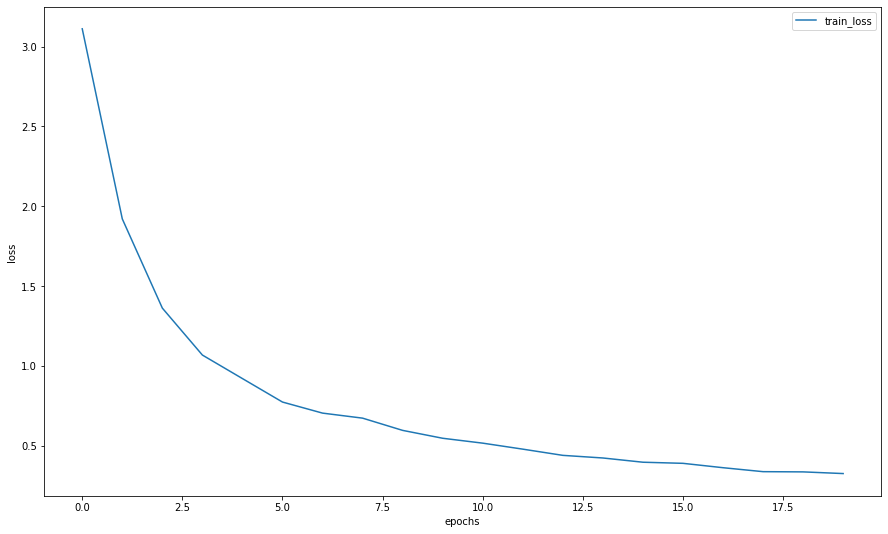

In [33]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [53]:
# Немного увеличенная простая нейросеть
class MySimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.linear1 = nn.Sequential(
            nn.Linear(96 * 5 * 5, 4096),
            nn.ReLU()
        )

        self.linear2 = nn.Sequential(
            nn.Linear(4096, 4096),
            nn.ReLU()
        )

        self.out = nn.Linear(4096, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        x = self.linear1(x)
        x = self.linear2(x)
        logits = self.out(x)
        return logits

In [57]:
model = MySimpleCnn(n_classes).to(DEVICE)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [58]:
history = train(model=model, loss=loss, optimizer=optimizer, epochs=20, batch_size=BATCH_SIZE, train_loader=train_loader, scheduler=scheduler)

epoch:   5%|▌         | 1/20 [01:58<37:28, 118.34s/it]

loss 3.302203492417142

Epoch 001 train_loss: 3.3022 train_acc 0.1320


epoch:  10%|█         | 2/20 [03:56<35:25, 118.08s/it]

loss 2.0774846685170183

Epoch 002 train_loss: 2.0775 train_acc 0.4279


epoch:  15%|█▌        | 3/20 [05:53<33:22, 117.80s/it]

loss 1.246113833829619

Epoch 003 train_loss: 1.2461 train_acc 0.6475


epoch:  20%|██        | 4/20 [07:48<31:08, 116.80s/it]

loss 0.825603053953965

Epoch 004 train_loss: 0.8256 train_acc 0.7655


epoch:  25%|██▌       | 5/20 [09:47<29:20, 117.36s/it]

loss 0.6119709782779675

Epoch 005 train_loss: 0.6120 train_acc 0.8271


epoch:  30%|███       | 6/20 [11:43<27:19, 117.11s/it]

loss 0.4913673866058805

Epoch 006 train_loss: 0.4914 train_acc 0.8598


epoch:  35%|███▌      | 7/20 [13:38<25:12, 116.32s/it]

loss 0.39565264071753287

Epoch 007 train_loss: 0.3957 train_acc 0.8848


epoch:  40%|████      | 8/20 [15:30<22:57, 114.76s/it]

loss 0.2907948662096548

Epoch 008 train_loss: 0.2908 train_acc 0.9158


epoch:  45%|████▌     | 9/20 [17:23<20:57, 114.34s/it]

loss 0.2561885190338661

Epoch 009 train_loss: 0.2562 train_acc 0.9287


epoch:  50%|█████     | 10/20 [19:16<18:59, 113.91s/it]

loss 0.23334534827673

Epoch 010 train_loss: 0.2333 train_acc 0.9347


epoch:  55%|█████▌    | 11/20 [21:10<17:05, 113.94s/it]

loss 0.20532440351131784

Epoch 011 train_loss: 0.2053 train_acc 0.9423


epoch:  60%|██████    | 12/20 [23:04<15:11, 113.98s/it]

loss 0.20213754989998012

Epoch 012 train_loss: 0.2021 train_acc 0.9425


epoch:  65%|██████▌   | 13/20 [24:57<13:15, 113.60s/it]

loss 0.1945202810194092

Epoch 013 train_loss: 0.1945 train_acc 0.9448


epoch:  70%|███████   | 14/20 [26:53<11:26, 114.46s/it]

loss 0.1774755209789014

Epoch 014 train_loss: 0.1775 train_acc 0.9500


epoch:  75%|███████▌  | 15/20 [28:48<09:32, 114.47s/it]

loss 0.166473516753666

Epoch 015 train_loss: 0.1665 train_acc 0.9533


epoch:  80%|████████  | 16/20 [30:42<07:37, 114.39s/it]

loss 0.1646529847881225

Epoch 016 train_loss: 0.1647 train_acc 0.9540


epoch:  85%|████████▌ | 17/20 [32:39<05:45, 115.23s/it]

loss 0.17023510418297347

Epoch 017 train_loss: 0.1702 train_acc 0.9529


epoch:  90%|█████████ | 18/20 [34:33<03:49, 114.79s/it]

loss 0.15917253200695655

Epoch 018 train_loss: 0.1592 train_acc 0.9546


epoch:  95%|█████████▌| 19/20 [36:28<01:54, 114.92s/it]

loss 0.1661774018394197

Epoch 019 train_loss: 0.1662 train_acc 0.9532


epoch: 100%|██████████| 20/20 [38:22<00:00, 115.15s/it]

loss 0.15330523080717717

Epoch 020 train_loss: 0.1533 train_acc 0.9564


In [59]:
loss, acc = zip(*history)

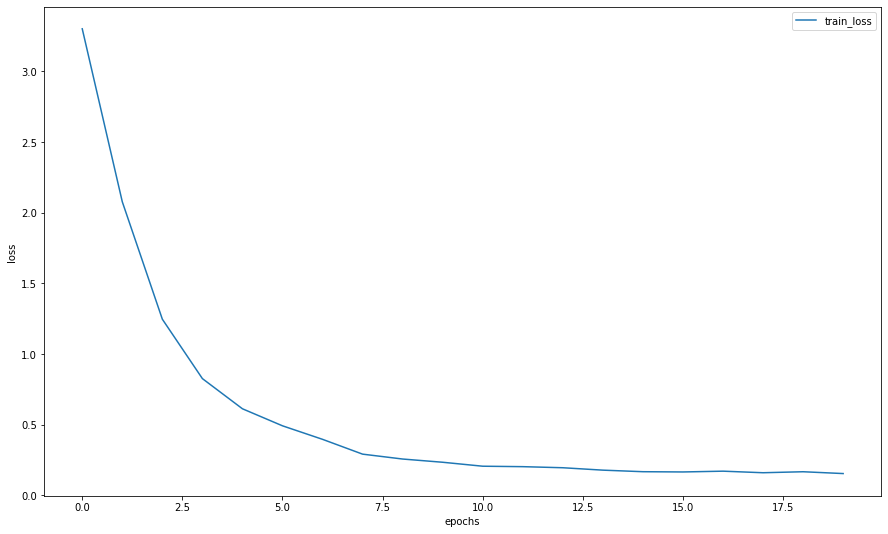

In [60]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [47]:
class TestDataset(Dataset):
    def __init__(self, files):
        self.files = files

    def __getitem__(self, index):
        test_transforms = transforms.Compose([
            transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
            transforms.Lambda(lambda x: np.array(x, dtype="float32") / 255),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) ,
        ])
        img = Image.open(self.files[index]).convert('RGB')
        return test_transforms(img)
    
    def __len__(self):
        return len(self.files)

In [48]:
test_dataset = TestDataset(test_files)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE)
probs = predict(model, test_loader)
preds = [train_dataset.classes[i] for i in probs.argmax(axis=-1)]
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
simple_cnn

SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=2400, out_features=42, bias=True)


In [ ]:
! ls 

characters_illustration.png  label_encoder.pkl	sample_submission.csv  train
drive			     sample_data	testset


In [49]:
import pandas as pd
my_submit = pd.read_csv("sample_submission.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [50]:
my_submit.to_csv('drive/MyDrive/Colab_Notebooks/simple_cnn_baseline.csv', index=False)

В соревнованиях был получен скор 0.97